Loaded 686 unique genes from ADMA sheet.
✅ Saved full intersecting gene tables (with all DE columns) to 'plots/sup_THP-1_intersecting_genes.xlsx'


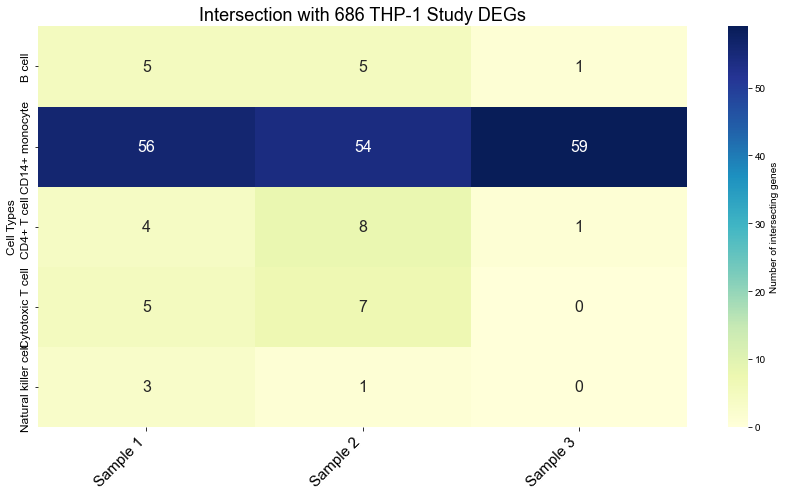

✅ Saved intersection matrix to 'plots/sup_gene_intersection_matrix.csv'


In [22]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ------------------------------
# CONFIGURATION
# ------------------------------
matplotlib.rcParams['font.family'] = 'Arial'
adma_path = Path("../data/adma202413413-sup-0002-tables1.xlsx")
de_path = Path("../data/de_results_CoDi_dist.xlsx")
output_csv = Path("plots/sup_gene_intersection_matrix.csv")
output_excel = Path("plots/sup_THP-1_intersecting_genes.xlsx")

# ------------------------------
# 1. Load gene list from ADMA (first sheet)
# ------------------------------
adma_df = pd.read_excel(adma_path, sheet_name=0)
adma_genes = adma_df.iloc[:, 0].dropna().astype(str).str.strip().unique().tolist()
print(f"Loaded {len(adma_genes)} unique genes from ADMA sheet.")

# ------------------------------
# 2. Load all DE sheets and compute intersections
# ------------------------------
de_sheets = pd.read_excel(de_path, sheet_name=None)
intersections = []

# Prepare Excel writer for saving intersecting gene tables
output_excel.parent.mkdir(parents=True, exist_ok=True)
writer = pd.ExcelWriter(output_excel, engine="xlsxwriter")

for sheet_name, df in de_sheets.items():
    parts = sheet_name.split("_sample_")
    if len(parts) < 2:
        print(f"⚠️ Skipping malformed sheet name: {sheet_name}")
        continue

    cell_type = parts[0].replace("_", " ")
    sample = "Sample " + parts[1]

    # Extract gene column (first column assumed)
    genes = df.iloc[:, 0].dropna().astype(str).str.strip().unique().tolist()

    # Compute intersection
    intersect_genes = sorted(set(adma_genes) & set(genes))
    intersect_count = len(intersect_genes)

    # Record intersection count
    intersections.append({
        "CellType": cell_type,
        "Sample": sample,
        "IntersectCount": intersect_count
    })

    # Save all intersecting rows (keep all DE columns)
    if intersect_count > 0:
        # Keep only rows where the first column (gene) is in intersecting set
        gene_col = df.columns[0]
        df_filtered = df[df[gene_col].astype(str).str.strip().isin(intersect_genes)]

        # Sort by gene name for consistency
        df_filtered = df_filtered.sort_values(by=gene_col)

        # Write to Excel (sheet name trimmed to ≤31 characters)
        df_filtered.to_excel(writer, sheet_name=sheet_name[:31], index=False)

# Save Excel with all sheets
writer.close()
print(f"✅ Saved full intersecting gene tables (with all DE columns) to '{output_excel}'")

# ------------------------------
# 3. Create intersection matrix (pivot)
# ------------------------------
intersections_df = pd.DataFrame(intersections)
heatmap_df = intersections_df.pivot_table(
    index="CellType",
    columns="Sample",
    values="IntersectCount",
    fill_value=0
).astype(int)

# ------------------------------
# 4. Visualize as heatmap
# ------------------------------
plt.figure(figsize=(12, 7))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar_kws={'label': 'Number of intersecting genes'},
    annot_kws={"size": 16}
)

plt.xticks(fontsize=15, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.title("Intersection with 686 THP-1 Study DEGs", fontsize=18)
plt.xlabel("", fontsize=14)
plt.ylabel("Cell Types", fontsize=12)
plt.tight_layout()
plt.savefig("sup_THP-1_intersecting_genes.pdf", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------
# 5. Save intersection summary
# ------------------------------
output_csv.parent.mkdir(parents=True, exist_ok=True)
heatmap_df.to_csv(output_csv)
print(f"✅ Saved intersection matrix to '{output_csv}'")


Loaded 686 unique genes from ADMA sheet.
✅ Saved full intersecting gene tables to 'plots/sup_THP-1_intersecting_genes.xlsx'


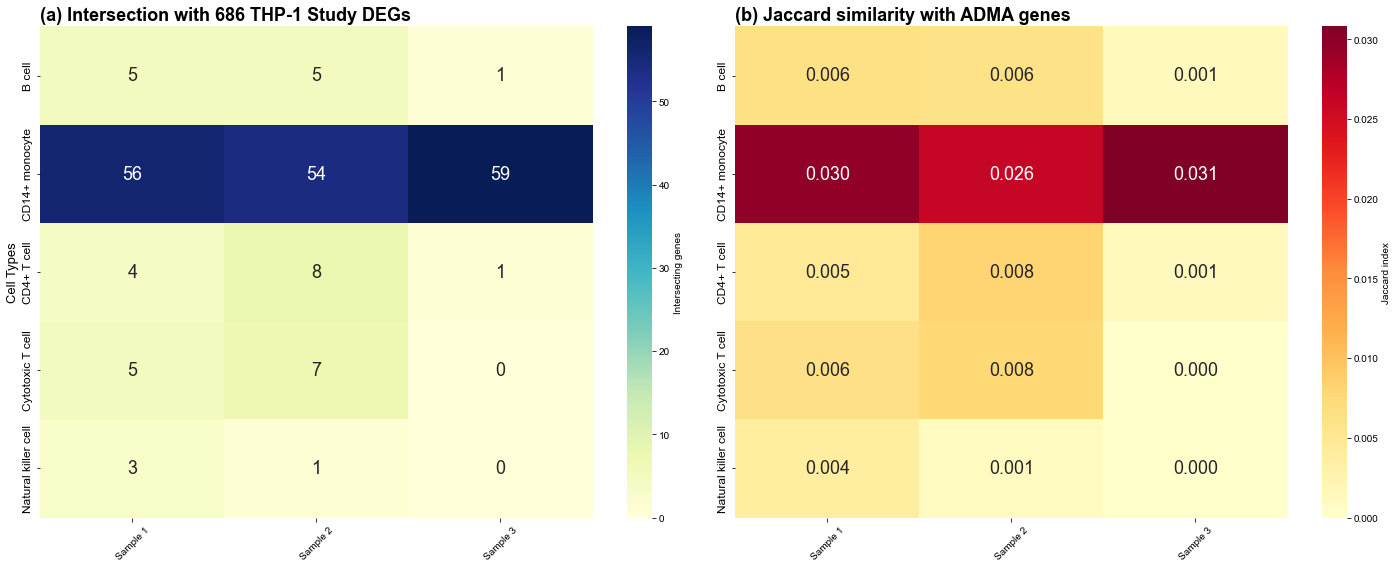

✅ Saved intersection and Jaccard matrices.


In [7]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ------------------------------
# CONFIGURATION
# ------------------------------
matplotlib.rcParams['font.family'] = 'Arial'
adma_path = Path("../data/adma202413413-sup-0002-tables1.xlsx")
de_path = Path("../data/de_results_CoDi_dist.xlsx")
output_csv = Path("plots/sup_gene_intersection_matrix.csv")
output_excel = Path("plots/sup_THP-1_intersecting_genes.xlsx")

# ------------------------------
# 1. Load gene list from ADMA (first sheet)
# ------------------------------
adma_df = pd.read_excel(adma_path, sheet_name=0)
adma_genes = adma_df.iloc[:, 0].dropna().astype(str).str.strip().unique().tolist()
print(f"Loaded {len(adma_genes)} unique genes from ADMA sheet.")

# ------------------------------
# 2. Load all DE sheets and compute intersections & Jaccard
# ------------------------------
de_sheets = pd.read_excel(de_path, sheet_name=None)
intersections = []

output_excel.parent.mkdir(parents=True, exist_ok=True)
writer = pd.ExcelWriter(output_excel, engine="xlsxwriter")

for sheet_name, df in de_sheets.items():
    parts = sheet_name.split("_sample_")
    if len(parts) < 2:
        print(f"⚠️ Skipping malformed sheet name: {sheet_name}")
        continue

    cell_type = parts[0].replace("_", " ")
    sample = "Sample " + parts[1]

    genes = df.iloc[:, 0].dropna().astype(str).str.strip().unique().tolist()
    intersect_genes = sorted(set(adma_genes) & set(genes))
    union_genes = set(adma_genes) | set(genes)
    intersect_count = len(intersect_genes)
    jaccard_score = len(intersect_genes) / len(union_genes) if union_genes else 0

    intersections.append({
        "CellType": cell_type,
        "Sample": sample,
        "IntersectCount": intersect_count,
        "Jaccard": jaccard_score
    })

    if intersect_count > 0:
        gene_col = df.columns[0]
        df_filtered = df[df[gene_col].astype(str).str.strip().isin(intersect_genes)]
        df_filtered = df_filtered.sort_values(by=gene_col)
        df_filtered.to_excel(writer, sheet_name=sheet_name[:31], index=False)

writer.close()
print(f"✅ Saved full intersecting gene tables to '{output_excel}'")

# ------------------------------
# 3. Create pivot tables for heatmaps
# ------------------------------
intersections_df = pd.DataFrame(intersections)
heatmap_count = intersections_df.pivot_table(
    index="CellType", columns="Sample", values="IntersectCount", fill_value=0
).astype(int)

heatmap_jaccard = intersections_df.pivot_table(
    index="CellType", columns="Sample", values="Jaccard", fill_value=0
)

# ------------------------------
# 4. Create Nature-style 2-panel figure
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- (a) Intersection counts ---
sns.heatmap(
    heatmap_count,
    annot=True, fmt="d", cmap="YlGnBu",
    cbar_kws={'label': 'Intersecting genes'},
    ax=axes[0], annot_kws={"size": 18}
)
axes[0].set_title("(a) Intersection with 686 THP-1 Study DEGs", fontsize=18, loc="left", fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Cell Types", fontsize=13)
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].tick_params(axis='y', labelsize=12)

# --- (b) Jaccard index ---
sns.heatmap(
    heatmap_jaccard,
    annot=True, fmt=".3f", cmap="YlOrRd",
    cbar_kws={'label': 'Jaccard index'},
    ax=axes[1], annot_kws={"size": 18}
)
axes[1].set_title("(b) Jaccard similarity with ADMA genes", fontsize=18, loc="left", fontweight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("sup_THP-1_intersecting_genes_combined.pdf", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------
# 5. Save intersection summaries
# ------------------------------
output_csv.parent.mkdir(parents=True, exist_ok=True)
heatmap_count.to_csv("plots/sup_THP-1_intersection_counts.csv")
heatmap_jaccard.to_csv("plots/sup_THP-1_jaccard_scores.csv")
print("✅ Saved intersection and Jaccard matrices.")


Loaded 686 unique genes from ADMA sheet.
✅ Saved full intersecting gene tables to 'plots/sup_THP-1_intersecting_genes.xlsx'


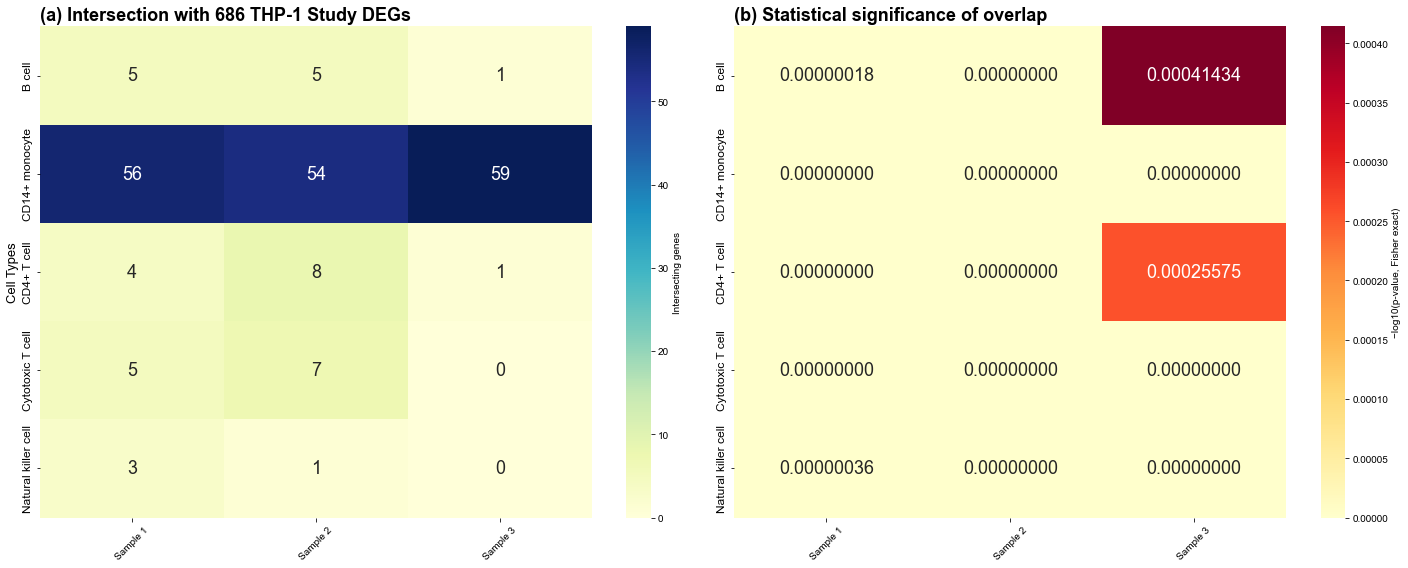

✅ Saved intersection and Fisher significance matrices.


In [8]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import fisher_exact
import numpy as np

# ------------------------------
# CONFIGURATION
# ------------------------------
matplotlib.rcParams['font.family'] = 'Arial'
adma_path = Path("../data/adma202413413-sup-0002-tables1.xlsx")
de_path = Path("../data/de_results_CoDi_dist.xlsx")
output_csv = Path("plots/sup_gene_intersection_matrix.csv")
output_excel = Path("plots/sup_THP-1_intersecting_genes.xlsx")

# ------------------------------
# 1. Load gene list from ADMA (first sheet)
# ------------------------------
adma_df = pd.read_excel(adma_path, sheet_name=0)
adma_genes = adma_df.iloc[:, 0].dropna().astype(str).str.strip().unique().tolist()
print(f"Loaded {len(adma_genes)} unique genes from ADMA sheet.")

# ------------------------------
# 2. Load all DE sheets and compute intersections & Fisher exact test
# ------------------------------
de_sheets = pd.read_excel(de_path, sheet_name=None)
intersections = []

output_excel.parent.mkdir(parents=True, exist_ok=True)
writer = pd.ExcelWriter(output_excel, engine="xlsxwriter")

# Define the gene universe (all unique genes across all DE lists and ADMA)
all_de_genes = set()
for df in de_sheets.values():
    all_de_genes.update(df.iloc[:, 0].dropna().astype(str).str.strip().tolist())
gene_universe = set(adma_genes) | all_de_genes
N = len(gene_universe)

for sheet_name, df in de_sheets.items():
    parts = sheet_name.split("_sample_")
    if len(parts) < 2:
        print(f"⚠️ Skipping malformed sheet name: {sheet_name}")
        continue

    cell_type = parts[0].replace("_", " ")
    sample = "Sample " + parts[1]

    genes = df.iloc[:, 0].dropna().astype(str).str.strip().unique().tolist()
    A = set(adma_genes)
    B = set(genes)
    a = len(A & B)
    b = len(B - A)
    c = len(A - B)
    d = N - (a + b + c)
    table = [[a, b], [c, d]]

    # Fisher’s exact test (greater → enrichment)
    oddsratio, pval = fisher_exact(table, alternative="greater")

    # Avoid log(0)
    neglogp = -np.log10(pval) if pval > 0 else np.nan

    intersections.append({
        "CellType": cell_type,
        "Sample": sample,
        "IntersectCount": a,
        "Fisher_p": pval,
        "-log10_p": neglogp
    })

    if a > 0:
        gene_col = df.columns[0]
        df_filtered = df[df[gene_col].astype(str).str.strip().isin(A & B)]
        df_filtered = df_filtered.sort_values(by=gene_col)
        df_filtered.to_excel(writer, sheet_name=sheet_name[:31], index=False)

writer.close()
print(f"✅ Saved full intersecting gene tables to '{output_excel}'")

# ------------------------------
# 3. Create pivot tables for heatmaps
# ------------------------------
intersections_df = pd.DataFrame(intersections)
heatmap_count = intersections_df.pivot_table(
    index="CellType", columns="Sample", values="IntersectCount", fill_value=0
).astype(int)

heatmap_sig = intersections_df.pivot_table(
    index="CellType", columns="Sample", values="-log10_p", fill_value=0
)

# ------------------------------
# 4. Create Nature-style 2-panel figure
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- (a) Intersection counts ---
sns.heatmap(
    heatmap_count,
    annot=True, fmt="d", cmap="YlGnBu",
    cbar_kws={'label': 'Intersecting genes'},
    ax=axes[0], annot_kws={"size": 18}
)
axes[0].set_title("(a) Intersection with 686 THP-1 Study DEGs", fontsize=18, loc="left", fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Cell Types", fontsize=13)
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].tick_params(axis='y', labelsize=12)

# --- (b) Fisher’s significance (−log10 p) ---
sns.heatmap(
    heatmap_sig,
    annot=True, fmt=".8f", cmap="YlOrRd",
    cbar_kws={'label': '−log10(p-value, Fisher exact)'},
    ax=axes[1], annot_kws={"size": 18}
)
axes[1].set_title("(b) Statistical significance of overlap", fontsize=18, loc="left", fontweight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("sup_THP-1_intersecting_genes_fisher.pdf", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------
# 5. Save intersection summaries
# ------------------------------
output_csv.parent.mkdir(parents=True, exist_ok=True)
heatmap_count.to_csv("plots/sup_THP-1_intersection_counts.csv")
heatmap_sig.to_csv("plots/sup_THP-1_fisher_significance.csv")
print("✅ Saved intersection and Fisher significance matrices.")
